<a href="https://colab.research.google.com/github/kkkaeun/AImodel/blob/main/AImodel_240726.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.layers import Dense, Input, LSTM, GRU, Dropout, Conv1D, Concatenate
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras import layers

from tensorflow.python.framework.ops import disable_eager_execution
tf.compat.v1.keras.backend.clear_session()
disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
window_size = 40
start_point = 5

# 데이터 전처리

In [ ]:
def input_data(input_path, start_point, window_size):
  df = pd.read_csv(input_path)
  train_X = df[['dX', 'dY',  'dv_X',  'dv_Y', 'Roll', 'Pitch', 'Heading']]
  train_X = train_X.astype(np.float32)
  total_timestamps = len(train_X)
  num_windows = total_timestamps - window_size + 1 - start_point

  windowed_data = np.zeros((num_windows, window_size, 7), dtype = np.float32)

  for i in range(num_windows):
      windowed_data[i] = train_X[i:i+window_size]

  x_data = windowed_data
  x_data = np.array(x_data)

  return x_data

In [ ]:
def label_data(output_path,start_point, window_size):
  df = pd.read_csv(output_path, usecols=[0,1], header=None, names=['North', 'East'])
  delta_data = df.diff(axis=0)
  total_timestamps = len(delta_data)
  num_windows = total_timestamps - window_size + 1 - start_point

  shifted = delta_data[['North', 'East']].copy()

  shifted['Pred_N'] = shifted['North'].shift(-window_size)
  shifted['Pred_E'] = shifted['East'].shift(-window_size)

  shifted.fillna(method='ffill', inplace = True)
  train_y=shifted[['Pred_N', 'Pred_E']][:num_windows]
  y_data = train_y.values

  print(y_data.shape)
  return y_data

In [ ]:
#input_120219 = input_data('/content/drive/MyDrive/trainset/120219_odo.csv', start_point, window_size)
#input_120317 = input_data('/content/drive/MyDrive/trainset/120317_odo.csv', start_point, window_size)
#input_120325 = input_data('/content/drive/MyDrive/trainset/120325_odo.csv', start_point, window_size)
input_120331 = input_data('/content/drive/MyDrive/trainset/120331_odo.csv', start_point, window_size)
input_120429 = input_data('/content/drive/MyDrive/trainset/120429_odo.csv', start_point, window_size)
input_120511 = input_data('/content/drive/MyDrive/trainset/120511_odo.csv', start_point, window_size)
input_120526 = input_data('/content/drive/MyDrive/trainset/120526_odo.csv', start_point, window_size)
input_120804 = input_data('/content/drive/MyDrive/trainset/120804_odo.csv', start_point, window_size)
input_120820 = input_data('/content/drive/MyDrive/trainset/120820_odo.csv', start_point, window_size)
input_120928 = input_data('/content/drive/MyDrive/trainset/120928_odo.csv', start_point, window_size)
input_121028 = input_data('/content/drive/MyDrive/trainset/121028_odo.csv', start_point, window_size)
#input_121116 = input_data('/content/drive/MyDrive/trainset/121116_odo.csv', start_point, window_size)
#input_121117 = input_data('/content/drive/MyDrive/trainset/121117_odo.csv', start_point, window_size)
#input_130110 = input_data('/content/drive/MyDrive/trainset/130110_odo.csv', start_point, window_size)

In [ ]:
#label_120219 = label_data('/content/drive/MyDrive/trainset/120219_NEDgps.csv', start_point, window_size)
#label_120317 = label_data('/content/drive/MyDrive/trainset/120317_NEDgps.csv', start_point, window_size)
#label_120325 = label_data('/content/drive/MyDrive/trainset/120325_NEDgps.csv', start_point, window_size)
label_120331 = label_data('/content/drive/MyDrive/trainset/120331_NEDgps.csv', start_point, window_size)
label_120429 = label_data('/content/drive/MyDrive/trainset/120429_NEDgps.csv', start_point, window_size)
label_120511 = label_data('/content/drive/MyDrive/trainset/120511_NEDgps.csv', start_point, window_size)
label_120526 = label_data('/content/drive/MyDrive/trainset/120526_NEDgps.csv', start_point, window_size)
label_120804 = label_data('/content/drive/MyDrive/trainset/120804_NEDgps.csv', start_point, window_size)
label_120820 = label_data('/content/drive/MyDrive/trainset/120820_NEDgps.csv', start_point, window_size)
label_120928 = label_data('/content/drive/MyDrive/trainset/120928_NEDgps.csv', start_point, window_size)
label_121028 = label_data('/content/drive/MyDrive/trainset/121028_NEDgps.csv', start_point, window_size)
#label_121116 = label_data('/content/drive/MyDrive/trainset/121116_NEDgps.csv', start_point, window_size)
#label_121117 = label_data('/content/drive/MyDrive/trainset/121117_NEDgps.csv', start_point, window_size)
#label_130110 = label_data('/content/drive/MyDrive/trainset/130110_NEDgps.csv', start_point, window_size)

(197487, 2)
(281197, 2)
(224656, 2)
(293358, 2)
(340704, 2)
(272547, 2)
(176839, 2)
(197086, 2)


In [ ]:
# input과 label data들 concatenate
x_data = np.concatenate((input_120331, input_120429, input_120511, input_120526, input_120804, input_120820
                         , input_120928, input_121028), axis=0)
y_data = np.concatenate((label_120331, label_120429, label_120511, label_120526, label_120804, label_120820
                         , label_120928, label_121028), axis=0)

# 데이터 타입 변환
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

# 스케일러 초기화
sc_x = MinMaxScaler(feature_range=(-1, 1))
sc_y = MinMaxScaler(feature_range=(-1, 1))

# train-test split
train_x, val_x, train_y, val_y = train_test_split(x_data, y_data, test_size=0.33, shuffle=True, random_state=42)

# 3D 배열을 2D로 변환
train_x_2d = train_x.reshape(-1, train_x.shape[-1])
train_y_2d = train_y.reshape(-1, train_y.shape[-1])
val_x_2d = val_x.reshape(-1, val_x.shape[-1])
val_y_2d = val_y.reshape(-1, val_y.shape[-1])

# 스케일링 적용
x_train = sc_x.fit_transform(train_x_2d)
y_train = sc_y.fit_transform(train_y_2d)

x_val = sc_x.transform(val_x_2d)
y_val = sc_y.transform(val_y_2d)

# 다시 3D로 변환
x_train = x_train.reshape(train_x.shape)
y_train = y_train.reshape(train_y.shape)

x_val = x_val.reshape(val_x.shape)
y_val = y_val.reshape(val_y.shape)

print(x_train.shape)

(1329195, 40, 7)


# 모델 구현

In [ ]:
from tensorflow.keras import backend as K


def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.

    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.

    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.

    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.

    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

In [ ]:
    # Number of training samples.
    sample_count = x_train.shape[0]

    # Total epochs to train.
    epochs = 11

    # Number of warmup epochs.
    warmup_epoch = 10

    # Training batch size, set small value here for demonstration purpose.
    batch_size = 64

    # Base learning rate after warmup.
    learning_rate_base = 0.0001

    total_steps = int(epochs * sample_count / batch_size)

    # Compute the number of warmup batches.
    warmup_steps = int(warmup_epoch * sample_count / batch_size)

    # Compute the number of warmup batches.
    warmup_batches = warmup_epoch * sample_count / batch_size

    # Create the Learning rate scheduler.
    warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
                                            total_steps=total_steps,
                                            warmup_learning_rate=0.0,
                                            warmup_steps=warmup_steps,
                                            hold_base_rate_steps=0)


In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling1D

def Single_model():
    inp = Input(shape=(40, 7))
    x = Conv1D(filters=64, kernel_size=1, padding="causal", activation="relu", strides=1)(inp)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = Conv1D(filters=128, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = Conv1D(filters=256, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = Conv1D(filters=512, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = GRU(40, activation="tanh")(x)
    x = Dropout(0.25)(x)
    output = Dense(2, activation="linear")(x)

    model = Model(inputs=inp, outputs=output)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()

    return model

if __name__ == "__main__":
    model = Single_model()

    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

    history = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[warm_up_lr])

    model.save('my_model.h5')

    y_pred = model.predict(x_val)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40, 7)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 40, 64)            512       
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 20, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 20, 128)           8320      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 10, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 10, 256)           3302

1329195/1329195 [==============================] - 290s 218us/sample - loss: 0.0070 - mae: 0.0595 - val_loss: 0.0059 - val_mae: 0.0538
Epoch 2/11
1329195/1329195 [==============================] - 278s 209us/sample - loss: 0.0059 - mae: 0.0541 - val_loss: 0.0057 - val_mae: 0.0533
Epoch 3/11
1329195/1329195 [==============================] - 290s 218us/sample - loss: 0.0057 - mae: 0.0534 - val_loss: 0.0057 - val_mae: 0.0528
Epoch 4/11
1329195/1329195 [==============================] - 297s 223us/sample - loss: 0.0057 - mae: 0.0530 - val_loss: 0.0056 - val_mae: 0.0527
Epoch 5/11
1329195/1329195 [==============================] - 278s 209us/sample - loss: 0.0056 - mae: 0.0527 - val_loss: 0.0056 - val_mae: 0.0523
Epoch 6/11
1329195/1329195 [==============================] - 283s 213us/sample - loss: 0.0056 - mae: 0.0526 - val_loss: 0.0055 - val_mae: 0.0524
Epoch 7/11
1329195/1329195 [==============================] - 284s 213us/sample - loss: 0.0055 - mae: 0.0524 - val_loss: 0.0055 - val_m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


# 모델 학습 결과

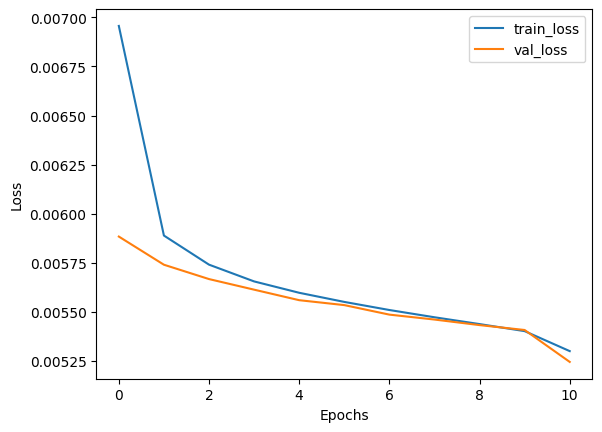

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 테스트

In [ ]:
def test_input(input_path, start_point, window_size, timestamps):
  df = pd.read_csv(input_path)
  df = df.iloc[start_point: start_point+timestamps]
  train_X = df[['dX', 'dY',  'dv_X',  'dv_Y', 'Roll', 'Pitch', 'Heading']]
  train_X = train_X.astype(np.float32)
  num_windows = timestamps - window_size + 1

  windowed_data = np.zeros((num_windows, window_size, 7), dtype = np.float32)

  for i in range(num_windows):
      windowed_data[i] = train_X[i:i+window_size]

  x_data = windowed_data
  x_data = np.array(x_data)

  return x_data

In [ ]:
def test_label(output_path,start_point, window_size, timestamps):
  df = pd.read_csv(output_path, usecols=[0,1], header=None, names=['North', 'East'])
  delta_data = df.diff(axis=0)
  num_windows = timestamps - window_size + 1

  delta_data = delta_data.iloc[start_point: start_point+timestamps]

  shifted = delta_data[['North', 'East']].copy()

  shifted['Pred_N'] = shifted['North'].shift(-window_size)
  shifted['Pred_E'] = shifted['East'].shift(-window_size)

  shifted.fillna(method='ffill', inplace = True)
  train_y=shifted[['Pred_N', 'Pred_E']][:num_windows]
  y_data = train_y.values

  print(y_data.shape)
  return y_data

In [ ]:
test_input1 = test_input('/content/drive/MyDrive/testset/120511_odo.csv', 88000, window_size, 2040)
test_label1 = test_label('/content/drive/MyDrive/testset/120511_NEDgps.csv', 88000, window_size, 2040)

test_input2 = test_input('/content/drive/MyDrive/testset/130405_odo.csv', 75000, window_size, 2040)
test_label2 = test_label('/content/drive/MyDrive/testset/130405_NEDgps.csv', 75000, window_size, 2040)

test_input3 = test_input('/content/drive/MyDrive/testset/130405_odo.csv', 123000, window_size, 2040)
test_label3 = test_label('/content/drive/MyDrive/testset/130405_NEDgps.csv', 123000, window_size, 2040)

(2001, 2)
(2001, 2)


120511 test 결과

=> 인풋 데이터와 겹치지 않는 경로

In [ ]:
x_data_TEST1 = test_input1.astype(np.float32)
y_data_TEST1 = test_label1.astype(np.float32)

# 3D 배열을 2D로 변환
x_data_2d_TEST1 = x_data_TEST1.reshape(-1, x_data_TEST1.shape[-1])
y_data_2d_TEST1 = y_data_TEST1.reshape(-1, y_data_TEST1.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST1 = sc_x.transform(x_data_2d_TEST1)
new_y_data_2d_TEST1 = sc_y.transform(y_data_2d_TEST1)

# 다시 3D로 변환
new_x_data_TEST1 = new_x_data_2d_TEST1.reshape(x_data_TEST1.shape)
new_y_data_TEST1 = new_y_data_2d_TEST1.reshape(y_data_TEST1.shape)

print(new_x_data_TEST1.shape)
print(new_y_data_TEST1.shape)

(2001, 40, 7)
(2001, 2)


In [ ]:
if __name__ == "__main__":

    y_pred_TEST1 = model.predict(new_x_data_TEST1)

In [ ]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST1 = np.array(y_pred_TEST1)
new_y_data_array_TEST1 = np.array(new_y_data_TEST1)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST1 = y_preds_array_TEST1.reshape(-1, y_preds_array_TEST1.shape[-1])
new_y_data_flat_TEST1 = new_y_data_array_TEST1.reshape(-1, new_y_data_array_TEST1.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST1 = sc_y.inverse_transform(y_preds_flat_TEST1)
rescaled_y_test_actual_N_E_TEST1 = sc_y.inverse_transform(new_y_data_flat_TEST1)

# 위도와 경도값만 가져오기
predicted_North_TEST1 = rescaled_y_preds_N_E_TEST1[:, 0]
predicted_East_TEST1 = rescaled_y_preds_N_E_TEST1[:, 1]

actual_North_TEST1 = rescaled_y_test_actual_N_E_TEST1[:, 0]
actual_East_TEST1 = rescaled_y_test_actual_N_E_TEST1[:, 1]

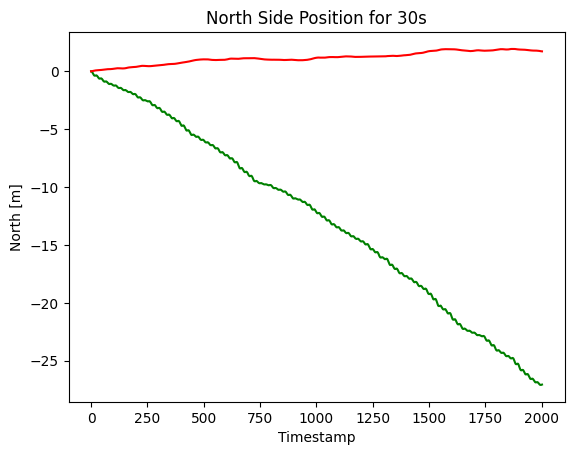

In [ ]:
# 초기값 설정
initial_North = test_label1[0][0]

# 실제 latitude 추정치 계산
North_predicted_TEST1 = [initial_North]
for change in predicted_North_TEST1:
    new_North_TEST1 = North_predicted_TEST1[-1] + change
    North_predicted_TEST1.append(new_North_TEST1)

# 실제 latitude 추정치 계산
North_actual_TEST1 = [initial_North]
for change in actual_North_TEST1:
    new_North_TEST1 = North_actual_TEST1[-1] + change
    North_actual_TEST1.append(new_North_TEST1)

# 시각화
plt.plot(North_actual_TEST1, label='Actual', c='g')
plt.plot(North_predicted_TEST1, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

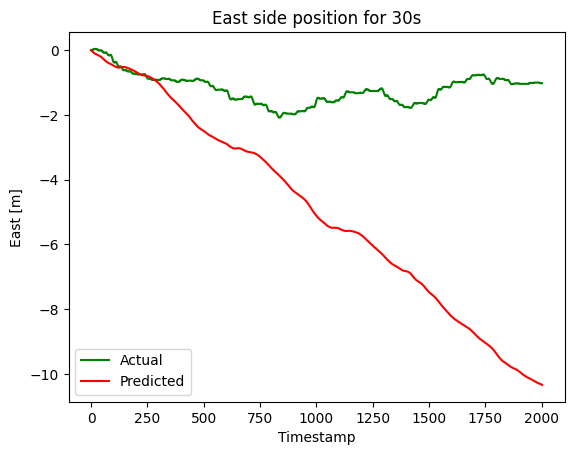

In [ ]:
# 초기값 설정
initial_East = test_label1[0][1]

# 실제 latitude 추정치 계산
East_predicted_TEST1 = [initial_East]
for change in predicted_East_TEST1:
    new_East_TEST1 = East_predicted_TEST1[-1] + change
    East_predicted_TEST1.append(new_East_TEST1)

# 실제 latitude 추정치 계산
East_actual_TEST1 = [initial_East]
for change in actual_East_TEST1:
    new_East_TEST1 = East_actual_TEST1[-1] + change
    East_actual_TEST1.append(new_East_TEST1)

# 시각화
plt.plot(East_actual_TEST1, label='Actual', c='g')
plt.plot(East_predicted_TEST1, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

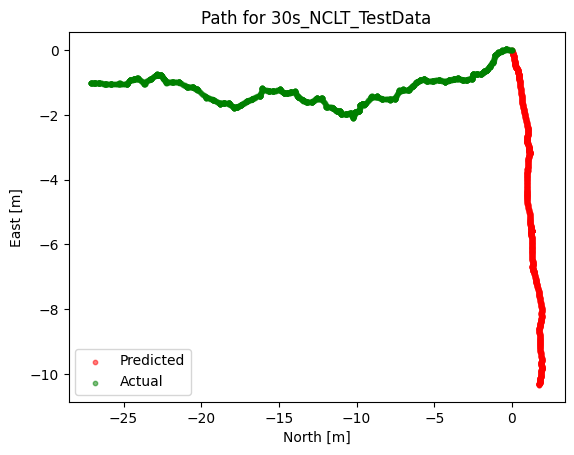

In [ ]:
plt.scatter(x=North_predicted_TEST1, y=East_predicted_TEST1, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST1, y=East_actual_TEST1, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

130405 test 결과

In [ ]:
x_data_TEST2 = test_input2.astype(np.float32)
y_data_TEST2 = test_label2.astype(np.float32)

# 3D 배열을 2D로 변환
x_data_2d_TEST2 = x_data_TEST2.reshape(-1, x_data_TEST2.shape[-1])
y_data_2d_TEST2 = y_data_TEST2.reshape(-1, y_data_TEST2.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST2 = sc_x.transform(x_data_2d_TEST2)
new_y_data_2d_TEST2 = sc_y.transform(y_data_2d_TEST2)

# 다시 3D로 변환
new_x_data_TEST2 = new_x_data_2d_TEST2.reshape(x_data_TEST2.shape)
new_y_data_TEST2 = new_y_data_2d_TEST2.reshape(y_data_TEST2.shape)

print(new_x_data_TEST2.shape)
print(new_y_data_TEST2.shape)

(2001, 40, 7)
(2001, 2)


In [ ]:
if __name__ == "__main__":

    y_pred_TEST2 = model.predict(new_x_data_TEST2)

In [ ]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST2 = np.array(y_pred_TEST2)
new_y_data_array_TEST2 = np.array(new_y_data_TEST2)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST2 = y_preds_array_TEST2.reshape(-1, y_preds_array_TEST2.shape[-1])
new_y_data_flat_TEST2 = new_y_data_array_TEST2.reshape(-1, new_y_data_array_TEST2.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST2 = sc_y.inverse_transform(y_preds_flat_TEST2)
rescaled_y_test_actual_N_E_TEST2 = sc_y.inverse_transform(new_y_data_flat_TEST2)

# 위도와 경도값만 가져오기
predicted_North_TEST2 = rescaled_y_preds_N_E_TEST2[:, 0]
predicted_East_TEST2 = rescaled_y_preds_N_E_TEST2[:, 1]

actual_North_TEST2 = rescaled_y_test_actual_N_E_TEST2[:, 0]
actual_East_TEST2 = rescaled_y_test_actual_N_E_TEST2[:, 1]

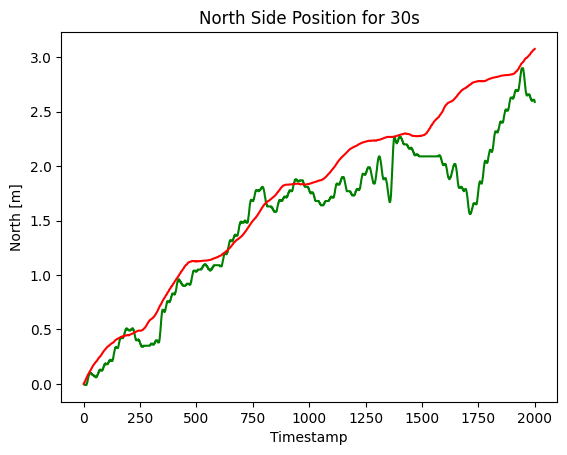

In [ ]:
# 초기값 설정
initial_North = test_label2[0][0]

# 실제 latitude 추정치 계산
North_predicted_TEST2 = [initial_North]
for change in predicted_North_TEST2:
    new_North_TEST2 = North_predicted_TEST2[-1] + change
    North_predicted_TEST2.append(new_North_TEST2)

# 실제 latitude 추정치 계산
North_actual_TEST2 = [initial_North]
for change in actual_North_TEST2:
    new_North_TEST2 = North_actual_TEST2[-1] + change
    North_actual_TEST2.append(new_North_TEST2)

# 시각화
plt.plot(North_actual_TEST2, label='Actual', c='g')
plt.plot(North_predicted_TEST2, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

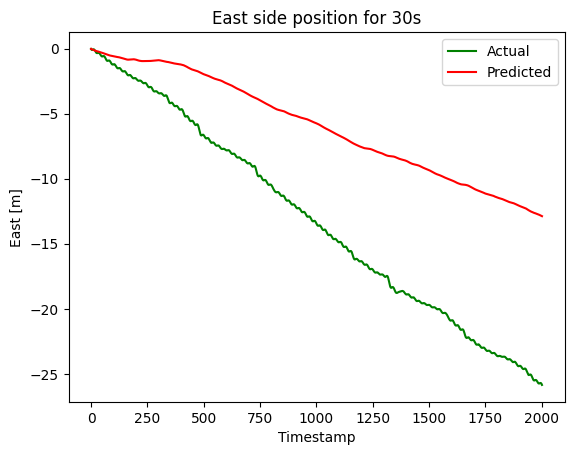

In [ ]:
# 초기값 설정
initial_East = test_label2[0][1]

# 실제 latitude 추정치 계산
East_predicted_TEST2 = [initial_East]
for change in predicted_East_TEST2:
    new_East_TEST2 = East_predicted_TEST2[-1] + change
    East_predicted_TEST2.append(new_East_TEST2)

# 실제 latitude 추정치 계산
East_actual_TEST2 = [initial_East]
for change in actual_East_TEST2:
    new_East_TEST2 = East_actual_TEST2[-1] + change
    East_actual_TEST2.append(new_East_TEST2)

# 시각화
plt.plot(East_actual_TEST2, label='Actual', c='g')
plt.plot(East_predicted_TEST2, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

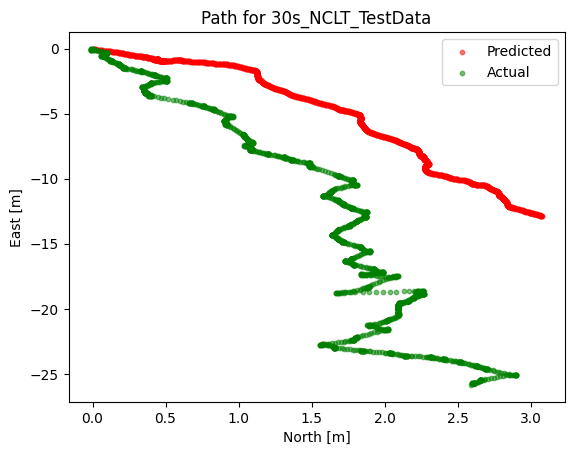

In [ ]:
plt.scatter(x=North_predicted_TEST2, y=East_predicted_TEST2, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST2, y=East_actual_TEST2, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

130405 test 결과2

In [ ]:
x_data_TEST3 = test_input3.astype(np.float32)
y_data_TEST3 = test_label3.astype(np.float32)

# 3D 배열을 2D로 변환
x_data_2d_TEST3 = x_data_TEST3.reshape(-1, x_data_TEST3.shape[-1])
y_data_2d_TEST3 = y_data_TEST3.reshape(-1, y_data_TEST3.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST3 = sc_x.transform(x_data_2d_TEST3)
new_y_data_2d_TEST3 = sc_y.transform(y_data_2d_TEST3)

# 다시 3D로 변환
new_x_data_TEST3 = new_x_data_2d_TEST3.reshape(x_data_TEST3.shape)
new_y_data_TEST3 = new_y_data_2d_TEST3.reshape(y_data_TEST3.shape)

print(new_x_data_TEST3.shape)
print(new_y_data_TEST3.shape)

(2001, 40, 7)
(2001, 2)


In [ ]:
if __name__ == "__main__":

    y_pred_TEST3 = model.predict(new_x_data_TEST3)

In [ ]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST3 = np.array(y_pred_TEST3)
new_y_data_array_TEST3 = np.array(new_y_data_TEST3)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST3 = y_preds_array_TEST3.reshape(-1, y_preds_array_TEST3.shape[-1])
new_y_data_flat_TEST3 = new_y_data_array_TEST3.reshape(-1, new_y_data_array_TEST3.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST3 = sc_y.inverse_transform(y_preds_flat_TEST3)
rescaled_y_test_actual_N_E_TEST3 = sc_y.inverse_transform(new_y_data_flat_TEST3)

# 위도와 경도값만 가져오기
predicted_North_TEST3 = rescaled_y_preds_N_E_TEST3[:, 0]
predicted_East_TEST3 = rescaled_y_preds_N_E_TEST3[:, 1]

actual_North_TEST3 = rescaled_y_test_actual_N_E_TEST3[:, 0]
actual_East_TEST3 = rescaled_y_test_actual_N_E_TEST3[:, 1]

In [ ]:
# 초기값 설정
initial_North = test_label3[0][0]

# 실제 latitude 추정치 계산
North_predicted_TEST3 = [initial_North]
for change in predicted_North_TEST3:
    new_North_TEST3 = North_predicted_TEST3[-1] + change
    North_predicted_TEST3.append(new_North_TEST3)

# 실제 latitude 추정치 계산
North_actual_TEST3 = [initial_North]
for change in actual_North_TEST3:
    new_North_TEST3 = North_actual_TEST3[-1] + change
    North_actual_TEST3.append(new_North_TEST3)

# 시각화
plt.plot(North_actual_TEST3, label='Actual', c='g')
plt.plot(North_predicted_TEST3, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

In [ ]:
# 초기값 설정
initial_East = test_label3[0][1]

# 실제 latitude 추정치 계산
East_predicted_TEST3 = [initial_East]
for change in predicted_East_TEST3:
    new_East_TEST3 = East_predicted_TEST3[-1] + change
    East_predicted_TEST3.append(new_East_TEST3)

# 실제 latitude 추정치 계산
East_actual_TEST3 = [initial_East]
for change in actual_East_TEST3:
    new_East_TEST3 = East_actual_TEST3[-1] + change
    East_actual_TEST3.append(new_East_TEST3)

# 시각화
plt.plot(East_actual_TEST3, label='Actual', c='g')
plt.plot(East_predicted_TEST3, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

In [ ]:
plt.scatter(x=North_predicted_TEST3, y=East_predicted_TEST3, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST3, y=East_actual_TEST3, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

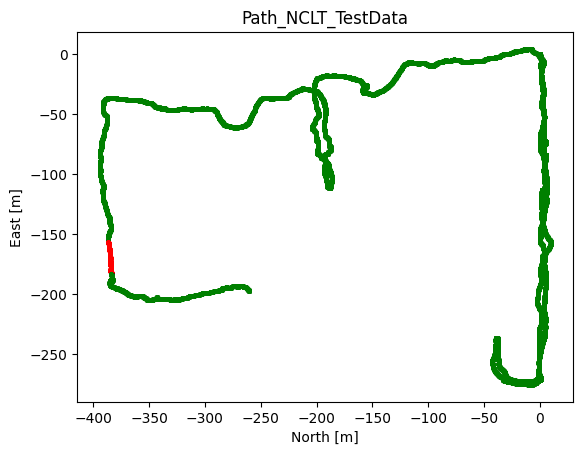

In [ ]:
# 구간 잡기용

df = pd.read_csv('/content/drive/MyDrive/testset/130405_NEDgps.csv', usecols=[0,1], header=None, names=['North', 'East'])
North = df['North']
East = df['East']

st = 123000
time = 2040

plt.scatter(x=North[:st], y=East[:st], c='g', s=5, alpha=0.5)
plt.scatter(x=North[st:st+time], y=East[st:st+time], c='r', s=5, alpha=0.5)
plt.scatter(x=North[st+time:], y=East[st+time:], c='g', s=5, alpha=0.5)

plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.title('Path_NCLT_TestData')
plt.show()